## Programming Assignment 3
UP feature and ensemble models exploration continues from the jump-start code below.


<h2><font color='#306998'><center>MSDS 451 Feature Engineering</center></font></h2>
<h2><center>Financial Machine Learning: Adding Features to the Mix</center></h2>
<h3><center>Thomas W. Miller, August 25, 2025</center></h3>
---

## Overview
We again use machine learning classifiers, including tree-based ensemble boosting and bagging methods, to predict the direction of oil futures (up or down) using a number of lagged price features. In particular, we look at daily closing spot prices for [West Texas Intermediate (ticker WTI)](https://en.wikipedia.org/wiki/West_Texas_Intermediate) with lags of one to seven days, as well as features based on opening, closing, high, and low price points, and daily trading volume.

Tree-based ensemble models for predicting the direction of daily returns set the stage for testing the predictive utility of additional features. The domain of potential features or leading indicators is wide, including those associated with other price series, economic indicators, international events, securities filings, analyst and news reports, and media measures. Here we explore a set of nine features defined from a range of exchange-traded funds (ETFs).

The model-building process demonstrated here can be employed for any asset or portfolio of assets.

The model building process involves these steps:

- Define price-based features for the target asset.
- Define binary features (Up or not Up) for other assets, economic measures, market measures, worldwide events, and media measures.
- Fit an ensemble model to the full set of features within a time series cross-validation design using a tree-structured ensemble with hyperparameters set to their default values. Note the test set classification performance in predicting movement (Up or not Up) in the target asset.
- Utilized randomized search across key hyperparameters to determine "best" settings.
- Use a hold-out test set to evaluate model performance with "best" hyperparameter settings.
- Rank the importance of features from the model evaluation, and select the best features for subsequent model development.
- Repeat the model-building process, adding new features to the mix.


### Import Libraries
We draw on Python packages for data manipulation and modeling. Most important are Polars, a high-performance alternative to Pandas for data manipulation, and Scikit-Learn for machine learning study design and modeling algorithms.

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.9 MB/s eta 0:00:00


In [ ]:
import os
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# datetime functions needed for filtering across DataFrames with differing time frame
from datetime import datetime, timezone

# Import Python Packages for data manipulation, data pipelines, and databases
import numpy as np
import pyarrow # foundation for polars
import polars as pl # DataFrame work superior to Pandas

# Plotting
import matplotlib.pyplot as plt
# Display static plots directly in the notebook output
%matplotlib inline
# create stylized visualizations, including heat maps
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (RandomizedSearchCV,
                                    TimeSeriesSplit)
from sklearn.model_selection import cross_validate

# utilized in all possible subsets classification work
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# needed for randomized search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# metrics in xgboost tuning and final model evaluation
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             roc_curve,
                             roc_auc_score,
                             RocCurveDisplay,
                             ConfusionMatrixDisplay,
                             confusion_matrix,
                             precision_score,
                             recall_score,
                             f1_score
                            )

from sklearn.ensemble import AdaBoostClassifier

from catboost import CatBoostClassifier

# XGBoost Package... more complete than SciKit-Learn boosting methods
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, plot_importance

from sklearn.ensemble import RandomForestClassifier

import warnings
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

### Retrieve Data
In previous work, we retrieved price data for WTI and nine ETFs from Yahoo Finance. The code for WTI is shown in the next commented-out cell.

In [ ]:
'''
Previous work to retrieve data from Yahoo Finance had this structure for each of the ETFs in the study

symbol = 'WTI'
start_date = '2000-01-01'
end_date = '2025-08-19'

ticker = yf.Ticker(symbol)
historical_data = ticker.history(start = start_date, end = end_date, period = '1mo')
print(historical_data)

print("type of historical_data", type(historical_data))

historical_data.to_csv("wti_daily_data.csv")
'''

'\nPrevious work to retrieve data from Yahoo Finance had this structure for each of the ETFs in the study\n\nsymbol = \'WTI\'\nstart_date = \'2000-01-01\'\nend_date = \'2025-08-19\'\n\nticker = yf.Ticker(symbol)\nhistorical_data = ticker.history(start = start_date, end = end_date, period = \'1mo\')\nprint(historical_data)\n\nprint("type of historical_data", type(historical_data))\n\nhistorical_data.to_csv("wti_daily_data.csv")\n'

### Polars DataFrame Development
The following code cell demonstrates Polars use with the time series DataFrame for our selected market/ticker, WTI.

In [ ]:
wti = pl.read_csv("/content/wti_daily_data.csv", try_parse_dates=True)

# check the original schema
print(wti.schema)

# drop useless columns Dividends and StockSplits
wti = wti.drop(['Dividends', 'StockSplits'])

# create lag price features
wti = wti.with_columns((pl.col('Close')).shift().alias('CloseLag1'))
wti = wti.with_columns((pl.col('CloseLag1')).shift().alias('CloseLag2'))
wti = wti.with_columns((pl.col('CloseLag2')).shift().alias('CloseLag3'))

# create high-minus-low (HML) for day and its lags
wti = wti.with_columns((pl.col('High') - pl.col('Low')).alias('HML'))
wti = wti.with_columns((pl.col('HML')).shift().alias('HMLLag1'))
wti = wti.with_columns((pl.col('HMLLag1')).shift().alias('HMLLag2'))
wti = wti.with_columns((pl.col('HMLLag2')).shift().alias('HMLLag3'))

# create a net change for the day as the open minus closing price OMC
# also create the corresponding lag metrics
wti = wti.with_columns((pl.col('Open') - pl.col('Close')).alias('OMC'))
wti = wti.with_columns((pl.col('OMC')).shift().alias('OMCLag1'))
wti = wti.with_columns((pl.col('OMCLag1')).shift().alias('OMCLag2'))
wti = wti.with_columns((pl.col('OMCLag2')).shift().alias('OMCLag3'))

# create volume lag metrics
wti = wti.with_columns((pl.col('Volume')).shift().alias('VolumeLag1'))
wti = wti.with_columns((pl.col('VolumeLag1')).shift().alias('VolumeLag2'))
wti = wti.with_columns((pl.col('VolumeLag2')).shift().alias('VolumeLag3'))

# compute 10-day exponential moving averages of closing prices
# compute acround CloseLag1 to avoid any "leakage" in explanatory variable set
# note also the 10-day buffer between train and test in time-series cross-validation
wti = wti.with_columns((pl.col('CloseLag1').ewm_mean(half_life=1,ignore_nulls=True)).alias('CloseEMA2'))
wti = wti.with_columns((pl.col('CloseLag1').ewm_mean(half_life=2,ignore_nulls=True)).alias('CloseEMA4'))
wti = wti.with_columns((pl.col('CloseLag1').ewm_mean(half_life=4,ignore_nulls=True)).alias('CloseEMA8'))

# log daily returns
wti = wti.with_columns(np.log(pl.col('Close')/pl.col('CloseLag1')).alias('LogReturn'))

# set volume features to Float64 for subsequent use in Numpy arrays
wti = wti.with_columns(
    pl.col('Volume').cast(pl.Float64).round(0),
    pl.col('VolumeLag1').cast(pl.Float64).round(0),
    pl.col('VolumeLag2').cast(pl.Float64).round(0),
    pl.col('VolumeLag3').cast(pl.Float64).round(0),
    )

# round other features to three decimal places for reporting and subsequent analytics
wti = wti.with_columns(
    pl.col('Open').round(3),
    pl.col('High').round(3),
    pl.col('Low').round(3),
    pl.col('Close').round(3),
    pl.col('CloseLag1').round(3),
    pl.col('CloseLag2').round(3),
    pl.col('CloseLag3').round(3),
    pl.col('HML').round(3),
    pl.col('HMLLag1').round(3),
    pl.col('HMLLag2').round(3),
    pl.col('HMLLag3').round(3),
    pl.col('OMC').round(3),
    pl.col('OMCLag1').round(3),
    pl.col('OMCLag2').round(3),
    pl.col('OMCLag3').round(3),
    pl.col('CloseEMA2').round(3),
    pl.col('CloseEMA4').round(3),
    pl.col('CloseEMA8').round(3))

# no correction for class imbalance in this analysis
# define binary target/response 1 = market price up since previous day, 0 = even or down
wti = wti.with_columns(pl.when(pl.col('LogReturn')>0).then(pl.lit(1)).otherwise(pl.lit(0)).alias('Target'))

# save to external comma-delimited text file for checking calculations in Excel
wti.write_csv("wti-with-computed-features.csv")

Schema({'Date': Datetime(time_unit='us', time_zone='UTC'), 'Open': Float64, 'High': Float64, 'Low': Float64, 'Close': Float64, 'Volume': Int64, 'Dividends': Float64, 'StockSplits': Float64})


### Descriptive Statistics for Price Features

In [ ]:
# Drop the rows with null values such as the initial lag rows
wti = wti.drop_nulls()

# Descriptive statistics
wtiStatistics = wti.drop('Date').describe()

print(wtiStatistics.columns)

wtiStatisticsToPrint = wtiStatistics.transpose(include_header=True).drop(['column_1', 'column_5', 'column_7'])

print(wtiStatisticsToPrint.schema)

with pl.Config(
    tbl_rows = 60,
    tbl_width_chars = 200,
    tbl_cols = -1,
    float_precision = 3,
    tbl_hide_dataframe_shape = True,
    tbl_hide_column_data_types = True):
    print(wtiStatisticsToPrint)



['statistic', 'Open', 'High', 'Low', 'Close', 'Volume', 'CloseLag1', 'CloseLag2', 'CloseLag3', 'HML', 'HMLLag1', 'HMLLag2', 'HMLLag3', 'OMC', 'OMCLag1', 'OMCLag2', 'OMCLag3', 'VolumeLag1', 'VolumeLag2', 'VolumeLag3', 'CloseEMA2', 'CloseEMA4', 'CloseEMA8', 'LogReturn', 'Target']
Schema({'column': String, 'column_0': String, 'column_2': String, 'column_3': String, 'column_4': String, 'column_6': String, 'column_8': String})
┌────────────┬──────────┬─────────────────────────┬─────────────────────┬─────────────────────┬───────────┬────────────────────┐
│ column     ┆ column_0 ┆ column_2                ┆ column_3            ┆ column_4            ┆ column_6  ┆ column_8           │
╞════════════╪══════════╪═════════════════════════╪═════════════════════╪═════════════════════╪═══════════╪════════════════════╡
│ statistic  ┆ count    ┆ mean                    ┆ std                 ┆ min                 ┆ 50%       ┆ max                │
│ Open       ┆ 5169.0   ┆ 9.888208357515962       ┆ 8.2437

### Base Feature List Defined on WTI Pricing Alone
Features or explanatory variables, also known as an independent variables, are used to predict the values of target variables. The initial list of featrues includes the price-based features defined above, everything except the continuous response **LogReturn** if we wanted to employ regression and the binary response **Target** for classification, which is the focus of this project. This complete feature list is used in evaluating all methods.

We retain Date and Target at this point... Date is needed to select across WTI and the many ETFs. Target is needed as the response in training. These will be dropped from the training features set later.

In [ ]:
# Select Features for the Model, exclude current day price variables ... no "leakage"
# note for moving averages, we have excluded the current day, and provide a 10-day gap
# so these may be included in the set
wti = wti.drop(['LogReturn', 'Open', 'High', 'Low', 'Close', 'Volume', 'HML', 'OMC'])
wti.head()

Date,CloseLag1,CloseLag2,CloseLag3,HMLLag1,HMLLag2,HMLLag3,OMCLag1,OMCLag2,OMCLag3,VolumeLag1,VolumeLag2,VolumeLag3,CloseEMA2,CloseEMA4,CloseEMA8,Target
"datetime[μs, UTC]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
2005-02-02 05:00:00 UTC,13.196,13.189,13.406,0.232,0.79,0.942,-0.007,0.217,0.725,656500.0,1.7768e6,9.8135e6,13.224,13.241,13.252,0
2005-02-03 05:00:00 UTC,13.196,13.196,13.189,0.152,0.232,0.79,0.029,-0.007,0.217,265300.0,656500.0,1.7768e6,13.209,13.224,13.234,1
2005-02-04 05:00:00 UTC,13.225,13.196,13.196,0.087,0.152,0.232,0.0,0.029,-0.007,303200.0,265300.0,656500.0,13.217,13.224,13.232,0
2005-02-07 05:00:00 UTC,13.189,13.225,13.196,0.275,0.087,0.152,0.072,0.0,0.029,361100.0,303200.0,265300.0,13.203,13.212,13.221,1
2005-02-08 05:00:00 UTC,13.218,13.189,13.225,0.196,0.275,0.087,0.152,0.072,0.0,161900.0,361100.0,303200.0,13.211,13.214,13.221,0


### Read Data for Nine Exchange Traded Funds
The following code cells read data from nine exchange-traded funds (ETFs) selected to cover a wide range of asset classes. All of these funds have about a billion or more assets under management (AUM). We note the range of dates covered in each ETF DataFrame. Later we will ensure that the same date ranges are covered by WTI and the nine ETFs. Beginning dates vary, but all time series end on August 19, 2025.

For each selected ETF, we compute a variable named **Up** that is 1 if the price of the ETF went up the previous day, zero if not.

In [ ]:
# work with SPY data
spy = pl.read_csv("/content/spy_daily_data.csv", try_parse_dates=True)

# drop useless columns Dividends, StockSplits, and CapitalGains
spy = spy.drop(['Dividends', 'StockSplits', 'CapitalGains'])

spy = spy.with_columns((pl.col('Close')).shift().alias('CloseLag1'))
spy = spy.with_columns((pl.col('CloseLag1')).shift().alias('CloseLag2'))
spy = spy.with_columns(pl.when(pl.col('CloseLag1')>pl.col('CloseLag2')).then(pl.lit(1)).otherwise(pl.lit(0)).alias('SPYUp'))
# check the schema
print(spy.schema)

# Drop initial lag row
spy = spy.drop_nulls()

spyStatistics = spy.describe()
print(spyStatistics.columns)
spyStatisticsToPrint = spyStatistics.transpose(include_header=True).drop(['column_1', 'column_5', 'column_6', 'column_7'])
print(wtiStatisticsToPrint.schema)
with pl.Config(
    tbl_rows = 60,
    tbl_width_chars = 200,
    tbl_cols = -1,
    float_precision = 3,
    tbl_hide_dataframe_shape = True,
    tbl_hide_column_data_types = True):
    print(spyStatisticsToPrint)

# print a few records at the beginning of the DataFrame
print(spy.head())

Schema({'Date': Datetime(time_unit='us', time_zone='UTC'), 'Open': Float64, 'High': Float64, 'Low': Float64, 'Close': Float64, 'Volume': Int64, 'CloseLag1': Float64, 'CloseLag2': Float64, 'SPYUp': Int32})
['statistic', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'CloseLag1', 'CloseLag2', 'SPYUp']
Schema({'column': String, 'column_0': String, 'column_2': String, 'column_3': String, 'column_4': String, 'column_6': String, 'column_8': String})
┌───────────┬──────────┬─────────────────────────────────┬────────────────────┬───────────────────────────┬───────────────────────────┐
│ column    ┆ column_0 ┆ column_2                        ┆ column_3           ┆ column_4                  ┆ column_8                  │
╞═══════════╪══════════╪═════════════════════════════════╪════════════════════╪═══════════════════════════╪═══════════════════════════╡
│ statistic ┆ count    ┆ mean                            ┆ std                ┆ min                       ┆ max                       │
│ Dat

In [ ]:
# work with GLD data
gld = pl.read_csv("/content/gld_daily_data.csv", try_parse_dates=True)

# drop useless columns Dividends, StockSplits, and CapitalGains
gld = gld.drop(['Dividends', 'StockSplits', 'CapitalGains'])

gld = gld.with_columns((pl.col('Close')).shift().alias('CloseLag1'))
gld = gld.with_columns((pl.col('CloseLag1')).shift().alias('CloseLag2'))
gld = gld.with_columns(pl.when(pl.col('CloseLag1')>pl.col('CloseLag2')).then(pl.lit(1)).otherwise(pl.lit(0)).alias('GLDUp'))
# check the schema
print(gld.schema)

# Drop initial lag row
gld = gld.drop_nulls()

gldStatistics = gld.describe()
print(gldStatistics.columns)
gldStatisticsToPrint = gldStatistics.transpose(include_header=True).drop(['column_1', 'column_5', 'column_6', 'column_7'])
print(wtiStatisticsToPrint.schema)
with pl.Config(
    tbl_rows = 60,
    tbl_width_chars = 200,
    tbl_cols = -1,
    float_precision = 3,
    tbl_hide_dataframe_shape = True,
    tbl_hide_column_data_types = True):
    print(gldStatisticsToPrint)

# print a few records at the beginning of the DataFrame
print(gld.head())

Schema({'Date': Datetime(time_unit='us', time_zone='UTC'), 'Open': Float64, 'High': Float64, 'Low': Float64, 'Close': Float64, 'Volume': Int64, 'CloseLag1': Float64, 'CloseLag2': Float64, 'GLDUp': Int32})
['statistic', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'CloseLag1', 'CloseLag2', 'GLDUp']
Schema({'column': String, 'column_0': String, 'column_2': String, 'column_3': String, 'column_4': String, 'column_6': String, 'column_8': String})
┌───────────┬──────────┬─────────────────────────────────┬─────────────────────┬───────────────────────────┬───────────────────────────┐
│ column    ┆ column_0 ┆ column_2                        ┆ column_3            ┆ column_4                  ┆ column_8                  │
╞═══════════╪══════════╪═════════════════════════════════╪═════════════════════╪═══════════════════════════╪═══════════════════════════╡
│ statistic ┆ count    ┆ mean                            ┆ std                 ┆ min                       ┆ max                       │
│

In [ ]:
# work with VGT data
vgt = pl.read_csv("/content/vgt_daily_data.csv", try_parse_dates=True)

# drop useless columns Dividends, StockSplits, and CapitalGains
vgt = vgt.drop(['Dividends', 'StockSplits', 'CapitalGains'])

vgt = vgt.with_columns((pl.col('Close')).shift().alias('CloseLag1'))
vgt = vgt.with_columns((pl.col('CloseLag1')).shift().alias('CloseLag2'))
vgt = vgt.with_columns(pl.when(pl.col('CloseLag1')>pl.col('CloseLag2')).then(pl.lit(1)).otherwise(pl.lit(0)).alias('VGTUp'))
# check the schema
print(vgt.schema)

# Drop initial lag row
vgt = vgt.drop_nulls()

vgtStatistics = vgt.describe()
print(vgtStatistics.columns)
vgtStatisticsToPrint = vgtStatistics.transpose(include_header=True).drop(['column_1', 'column_5', 'column_6', 'column_7'])
print(wtiStatisticsToPrint.schema)
with pl.Config(
    tbl_rows = 60,
    tbl_width_chars = 200,
    tbl_cols = -1,
    float_precision = 3,
    tbl_hide_dataframe_shape = True,
    tbl_hide_column_data_types = True):
    print(vgtStatisticsToPrint)

# print a few records at the beginning of the DataFrame
print(vgt.head())

Schema({'Date': Datetime(time_unit='us', time_zone='UTC'), 'Open': Float64, 'High': Float64, 'Low': Float64, 'Close': Float64, 'Volume': Int64, 'CloseLag1': Float64, 'CloseLag2': Float64, 'VGTUp': Int32})
['statistic', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'CloseLag1', 'CloseLag2', 'VGTUp']
Schema({'column': String, 'column_0': String, 'column_2': String, 'column_3': String, 'column_4': String, 'column_6': String, 'column_8': String})
┌───────────┬──────────┬─────────────────────────────────┬────────────────────┬───────────────────────────┬───────────────────────────┐
│ column    ┆ column_0 ┆ column_2                        ┆ column_3           ┆ column_4                  ┆ column_8                  │
╞═══════════╪══════════╪═════════════════════════════════╪════════════════════╪═══════════════════════════╪═══════════════════════════╡
│ statistic ┆ count    ┆ mean                            ┆ std                ┆ min                       ┆ max                       │
│ Dat

In [ ]:
# work with VB data
vb = pl.read_csv("/content/vb_daily_data.csv", try_parse_dates=True)

# drop useless columns Dividends, StockSplits, and CapitalGains
vb = vb.drop(['Dividends', 'StockSplits', 'CapitalGains'])

vb = vb.with_columns((pl.col('Close')).shift().alias('CloseLag1'))
vb = vb.with_columns((pl.col('CloseLag1')).shift().alias('CloseLag2'))
vb = vb.with_columns(pl.when(pl.col('CloseLag1')>pl.col('CloseLag2')).then(pl.lit(1)).otherwise(pl.lit(0)).alias('VBUp'))
# check the schema
print(vb.schema)

# Drop initial lag row
vb = vb.drop_nulls()

vbStatistics = vb.describe()
print(vbStatistics.columns)
vbStatisticsToPrint = vbStatistics.transpose(include_header=True).drop(['column_1', 'column_5', 'column_6', 'column_7'])
print(wtiStatisticsToPrint.schema)
with pl.Config(
    tbl_rows = 60,
    tbl_width_chars = 200,
    tbl_cols = -1,
    float_precision = 3,
    tbl_hide_dataframe_shape = True,
    tbl_hide_column_data_types = True):
    print(vbStatisticsToPrint)

# print a few records at the beginning of the DataFrame
print(vb.head())

Schema({'Date': Datetime(time_unit='us', time_zone='UTC'), 'Open': Float64, 'High': Float64, 'Low': Float64, 'Close': Float64, 'Volume': Int64, 'CloseLag1': Float64, 'CloseLag2': Float64, 'VBUp': Int32})
['statistic', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'CloseLag1', 'CloseLag2', 'VBUp']
Schema({'column': String, 'column_0': String, 'column_2': String, 'column_3': String, 'column_4': String, 'column_6': String, 'column_8': String})
┌───────────┬──────────┬─────────────────────────────────┬─────────────────────┬───────────────────────────┬───────────────────────────┐
│ column    ┆ column_0 ┆ column_2                        ┆ column_3            ┆ column_4                  ┆ column_8                  │
╞═══════════╪══════════╪═════════════════════════════════╪═════════════════════╪═══════════════════════════╪═══════════════════════════╡
│ statistic ┆ count    ┆ mean                            ┆ std                 ┆ min                       ┆ max                       │
│ D

In [ ]:
# work with IVE data
ive = pl.read_csv("/content/ive_daily_data.csv", try_parse_dates=True)

# drop useless columns Dividends, StockSplits, and CapitalGains
ive = ive.drop(['Dividends', 'StockSplits', 'CapitalGains'])

ive = ive.with_columns((pl.col('Close')).shift().alias('CloseLag1'))
ive = ive.with_columns((pl.col('CloseLag1')).shift().alias('CloseLag2'))
ive = ive.with_columns(pl.when(pl.col('CloseLag1')>pl.col('CloseLag2')).then(pl.lit(1)).otherwise(pl.lit(0)).alias('IVEUp'))
# check the schema
print(ive.schema)

# Drop initial lag row
ive = ive.drop_nulls()

iveStatistics = ive.describe()
print(iveStatistics.columns)
iveStatisticsToPrint = iveStatistics.transpose(include_header=True).drop(['column_1', 'column_5', 'column_6', 'column_7'])
print(wtiStatisticsToPrint.schema)
with pl.Config(
    tbl_rows = 60,
    tbl_width_chars = 200,
    tbl_cols = -1,
    float_precision = 3,
    tbl_hide_dataframe_shape = True,
    tbl_hide_column_data_types = True):
    print(iveStatisticsToPrint)

# print a few records at the beginning of the DataFrame
print(ive.head())

Schema({'Date': Datetime(time_unit='us', time_zone='UTC'), 'Open': Float64, 'High': Float64, 'Low': Float64, 'Close': Float64, 'Volume': Int64, 'CloseLag1': Float64, 'CloseLag2': Float64, 'IVEUp': Int32})
['statistic', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'CloseLag1', 'CloseLag2', 'IVEUp']
Schema({'column': String, 'column_0': String, 'column_2': String, 'column_3': String, 'column_4': String, 'column_6': String, 'column_8': String})
┌───────────┬──────────┬─────────────────────────────────┬─────────────────────┬───────────────────────────┬───────────────────────────┐
│ column    ┆ column_0 ┆ column_2                        ┆ column_3            ┆ column_4                  ┆ column_8                  │
╞═══════════╪══════════╪═════════════════════════════════╪═════════════════════╪═══════════════════════════╪═══════════════════════════╡
│ statistic ┆ count    ┆ mean                            ┆ std                 ┆ min                       ┆ max                       │
│

In [ ]:
# work with XLI data
xli = pl.read_csv("/content/xli_daily_data.csv", try_parse_dates=True)

# drop useless columns Dividends, StockSplits, and CapitalGains
xli = xli.drop(['Dividends', 'StockSplits', 'CapitalGains'])

xli = xli.with_columns((pl.col('Close')).shift().alias('CloseLag1'))
xli = xli.with_columns((pl.col('CloseLag1')).shift().alias('CloseLag2'))
xli = xli.with_columns(pl.when(pl.col('CloseLag1')>pl.col('CloseLag2')).then(pl.lit(1)).otherwise(pl.lit(0)).alias('XLIUp'))
# check the schema
print(xli.schema)

# Drop initial lag row
xli = xli.drop_nulls()

xliStatistics = xli.describe()
print(xliStatistics.columns)
xliStatisticsToPrint = xliStatistics.transpose(include_header=True).drop(['column_1', 'column_5', 'column_6', 'column_7'])
print(wtiStatisticsToPrint.schema)
with pl.Config(
    tbl_rows = 60,
    tbl_width_chars = 200,
    tbl_cols = -1,
    float_precision = 3,
    tbl_hide_dataframe_shape = True,
    tbl_hide_column_data_types = True):
    print(xliStatisticsToPrint)

# print a few records at the beginning of the DataFrame
print(xli.head())

Schema({'Date': Datetime(time_unit='us', time_zone='UTC'), 'Open': Float64, 'High': Float64, 'Low': Float64, 'Close': Float64, 'Volume': Int64, 'CloseLag1': Float64, 'CloseLag2': Float64, 'XLIUp': Int32})
['statistic', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'CloseLag1', 'CloseLag2', 'XLIUp']
Schema({'column': String, 'column_0': String, 'column_2': String, 'column_3': String, 'column_4': String, 'column_6': String, 'column_8': String})
┌───────────┬──────────┬─────────────────────────────────┬────────────────────┬───────────────────────────┬───────────────────────────┐
│ column    ┆ column_0 ┆ column_2                        ┆ column_3           ┆ column_4                  ┆ column_8                  │
╞═══════════╪══════════╪═════════════════════════════════╪════════════════════╪═══════════════════════════╪═══════════════════════════╡
│ statistic ┆ count    ┆ mean                            ┆ std                ┆ min                       ┆ max                       │
│ Dat

In [ ]:
# work with XLU data
xlu = pl.read_csv("/content/xlu_daily_data.csv", try_parse_dates=True)

# drop useless columns Dividends, StockSplits, and CapitalGains
xlu = xlu.drop(['Dividends', 'StockSplits', 'CapitalGains'])

xlu = xlu.with_columns((pl.col('Close')).shift().alias('CloseLag1'))
xlu = xlu.with_columns((pl.col('CloseLag1')).shift().alias('CloseLag2'))
xlu = xlu.with_columns(pl.when(pl.col('CloseLag1')>pl.col('CloseLag2')).then(pl.lit(1)).otherwise(pl.lit(0)).alias('XLUUp'))
# check the schema
print(xlu.schema)

# Drop initial lag row
xlu = xlu.drop_nulls()

xluStatistics = xlu.describe()
print(xluStatistics.columns)
xluStatisticsToPrint = xluStatistics.transpose(include_header=True).drop(['column_1', 'column_5', 'column_6', 'column_7'])
print(wtiStatisticsToPrint.schema)
with pl.Config(
    tbl_rows = 60,
    tbl_width_chars = 200,
    tbl_cols = -1,
    float_precision = 3,
    tbl_hide_dataframe_shape = True,
    tbl_hide_column_data_types = True):
    print(xluStatisticsToPrint)

# print a few records at the beginning of the DataFrame
print(xlu.head())

Schema({'Date': Datetime(time_unit='us', time_zone='UTC'), 'Open': Float64, 'High': Float64, 'Low': Float64, 'Close': Float64, 'Volume': Int64, 'CloseLag1': Float64, 'CloseLag2': Float64, 'XLUUp': Int32})
['statistic', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'CloseLag1', 'CloseLag2', 'XLUUp']
Schema({'column': String, 'column_0': String, 'column_2': String, 'column_3': String, 'column_4': String, 'column_6': String, 'column_8': String})
┌───────────┬──────────┬─────────────────────────────────┬─────────────────────┬───────────────────────────┬───────────────────────────┐
│ column    ┆ column_0 ┆ column_2                        ┆ column_3            ┆ column_4                  ┆ column_8                  │
╞═══════════╪══════════╪═════════════════════════════════╪═════════════════════╪═══════════════════════════╪═══════════════════════════╡
│ statistic ┆ count    ┆ mean                            ┆ std                 ┆ min                       ┆ max                       │
│

In [ ]:
# work with SLV data
slv = pl.read_csv("/content/slv_daily_data.csv", try_parse_dates=True)

# drop useless columns Dividends, StockSplits, and CapitalGains
slv = slv.drop(['Dividends', 'StockSplits', 'CapitalGains'])

slv = slv.with_columns((pl.col('Close')).shift().alias('CloseLag1'))
slv = slv.with_columns((pl.col('CloseLag1')).shift().alias('CloseLag2'))
slv = slv.with_columns(pl.when(pl.col('CloseLag1')>pl.col('CloseLag2')).then(pl.lit(1)).otherwise(pl.lit(0)).alias('SLVUp'))
# check the schema
print(slv.schema)

# Drop initial lag row
slv = slv.drop_nulls()

slvStatistics = slv.describe()
print(slvStatistics.columns)
slvStatisticsToPrint = slvStatistics.transpose(include_header=True).drop(['column_1', 'column_5', 'column_6', 'column_7'])
print(wtiStatisticsToPrint.schema)
with pl.Config(
    tbl_rows = 60,
    tbl_width_chars = 200,
    tbl_cols = -1,
    float_precision = 3,
    tbl_hide_dataframe_shape = True,
    tbl_hide_column_data_types = True):
    print(slvStatisticsToPrint)

# print a few records at the beginning of the DataFrame
print(slv.head())

Schema({'Date': Datetime(time_unit='us', time_zone='UTC'), 'Open': Float64, 'High': Float64, 'Low': Float64, 'Close': Float64, 'Volume': Int64, 'CloseLag1': Float64, 'CloseLag2': Float64, 'SLVUp': Int32})
['statistic', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'CloseLag1', 'CloseLag2', 'SLVUp']
Schema({'column': String, 'column_0': String, 'column_2': String, 'column_3': String, 'column_4': String, 'column_6': String, 'column_8': String})
┌───────────┬──────────┬─────────────────────────────────┬────────────────────┬───────────────────────────┬───────────────────────────┐
│ column    ┆ column_0 ┆ column_2                        ┆ column_3           ┆ column_4                  ┆ column_8                  │
╞═══════════╪══════════╪═════════════════════════════════╪════════════════════╪═══════════════════════════╪═══════════════════════════╡
│ statistic ┆ count    ┆ mean                            ┆ std                ┆ min                       ┆ max                       │
│ Dat

In [ ]:
# work with USO data
uso = pl.read_csv("/content/uso_daily_data.csv", try_parse_dates=True)

# drop useless columns Dividends, StockSplits, and CapitalGains
uso = uso.drop(['Dividends', 'StockSplits', 'CapitalGains'])

uso = uso.with_columns((pl.col('Close')).shift().alias('CloseLag1'))
uso = uso.with_columns((pl.col('CloseLag1')).shift().alias('CloseLag2'))
uso = uso.with_columns(pl.when(pl.col('CloseLag1')>pl.col('CloseLag2')).then(pl.lit(1)).otherwise(pl.lit(0)).alias('USOUp'))
# check the schema
print(uso.schema)

# Drop initial lag row
uso = uso.drop_nulls()

usoStatistics = uso.describe()
print(usoStatistics.columns)
usoStatisticsToPrint = usoStatistics.transpose(include_header=True).drop(['column_1', 'column_5', 'column_6', 'column_7'])
print(wtiStatisticsToPrint.schema)
with pl.Config(
    tbl_rows = 60,
    tbl_width_chars = 200,
    tbl_cols = -1,
    float_precision = 3,
    tbl_hide_dataframe_shape = True,
    tbl_hide_column_data_types = True):
    print(usoStatisticsToPrint)

# print a few records at the beginning of the DataFrame
print(uso.head())

Schema({'Date': Datetime(time_unit='us', time_zone='UTC'), 'Open': Float64, 'High': Float64, 'Low': Float64, 'Close': Float64, 'Volume': Int64, 'CloseLag1': Float64, 'CloseLag2': Float64, 'USOUp': Int32})
['statistic', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'CloseLag1', 'CloseLag2', 'USOUp']
Schema({'column': String, 'column_0': String, 'column_2': String, 'column_3': String, 'column_4': String, 'column_6': String, 'column_8': String})
┌───────────┬──────────┬─────────────────────────────────┬─────────────────────┬───────────────────────────┬───────────────────────────┐
│ column    ┆ column_0 ┆ column_2                        ┆ column_3            ┆ column_4                  ┆ column_8                  │
╞═══════════╪══════════╪═════════════════════════════════╪═════════════════════╪═══════════════════════════╪═══════════════════════════╡
│ statistic ┆ count    ┆ mean                            ┆ std                 ┆ min                       ┆ max                       │
│

In [ ]:
# Find earliest date that can be used across all DataFrames
minDateAll = max(min(wti['Date']),min(spy['Date']),min(gld['Date']),
                 min(vgt['Date']),min(vb['Date']),min(ive['Date']),
                 min(xli['Date']),min(xlu['Date']),min(slv['Date']),min(uso['Date']))

print("minimum Date on which to select, minDateAll:", minDateAll)

minimum Date on which to select, minDateAll: 2006-05-02 04:00:00+00:00


In [ ]:
# find latest date across all DataFrames

maxDateAll = min(max(wti['Date']),max(spy['Date']),max(gld['Date']),
                 max(vgt['Date']),max(vb['Date']),max(ive['Date']),
                 max(xli['Date']),max(xlu['Date']),max(slv['Date']),max(uso['Date']))

print("maximum Date on which to select, axDateAll:", maxDateAll)


maximum Date on which to select, axDateAll: 2025-08-19 04:00:00+00:00


In [ ]:
# select training data from minDateAll to 2024-12-31, test data all dates in 2025
beginTrain = minDateAll
endTrain = datetime(2024, 12, 31, tzinfo=timezone.utc)
beginTest = datetime(2025, 1, 1, tzinfo=timezone.utc)
endTest = maxDateAll
wtiTrain = wti.filter((pl.col('Date')>=beginTrain) & (pl.col('Date')<=endTrain))
wtiTest = wti.filter((pl.col('Date')>=beginTest) & (pl.col('Date')<=endTest))

print("Beginning of wti training set")
print(wtiTrain.head())
print("End of wti training set")
print(wtiTrain.tail())
print("Beginning of wti test set")
print(wtiTest.head())
print("End of wti test set")
print(wtiTest.tail())


Beginning of wti training set
shape: (5, 17)
┌─────────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬────────┐
│ Date        ┆ CloseLag1 ┆ CloseLag2 ┆ CloseLag3 ┆ … ┆ CloseEMA2 ┆ CloseEMA4 ┆ CloseEMA8 ┆ Target │
│ ---         ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---    │
│ datetime[μs ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ i32    │
│ , UTC]      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
╞═════════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪════════╡
│ 2006-05-02  ┆ 32.19     ┆ 31.062    ┆ 30.669    ┆ … ┆ 31.649    ┆ 31.684    ┆ 31.697    ┆ 1      │
│ 04:00:00    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ UTC         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ 2006-05-03  ┆ 33.471    ┆ 32.19     ┆ 31.062

### Define the WTI Target for Training and Test Sets
Using the dates defined by looking across all ETFs and the WTI time series.

In [ ]:
# Define and examine the target for classification model development
print(wtiTrain['Target'].value_counts())
yTrain = np.array(wtiTrain['Target'])

print(wtiTest['Target'].value_counts())
yTest = np.array(wtiTest['Target'])

shape: (2, 2)
┌────────┬───────┐
│ Target ┆ count │
│ ---    ┆ ---   │
│ i32    ┆ u32   │
╞════════╪═══════╡
│ 1      ┆ 2227  │
│ 0      ┆ 2471  │
└────────┴───────┘
shape: (2, 2)
┌────────┬───────┐
│ Target ┆ count │
│ ---    ┆ ---   │
│ i32    ┆ u32   │
╞════════╪═══════╡
│ 1      ┆ 72    │
│ 0      ┆ 85    │
└────────┴───────┘


### Remove Target from WTI Data Sets
The initial feature set will include price features from WTI. Having obtained the Target from both the training and test data for WTI, we remove it from the WTI feature set in both the training and test sets.

In [ ]:
# Having extracted the Target from the WTI training and test sets, we can delete it from the set of features
XTrain = wtiTrain.drop(['Target'])
XTrain.head()

XTest = wtiTest.drop(['Target'])
XTest.head()

Date,CloseLag1,CloseLag2,CloseLag3,HMLLag1,HMLLag2,HMLLag3,OMCLag1,OMCLag2,OMCLag3,VolumeLag1,VolumeLag2,VolumeLag3,CloseEMA2,CloseEMA4,CloseEMA8
"datetime[μs, UTC]",f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-01-02 05:00:00 UTC,1.628,1.638,1.579,0.059,0.108,0.098,0.0,-0.029,-0.01,2.2437e6,3.6429e6,2.5184e6,1.61,1.579,1.581
2025-01-03 05:00:00 UTC,1.746,1.628,1.638,0.128,0.059,0.108,-0.078,0.0,-0.029,3.4821e6,2.2437e6,3.6429e6,1.678,1.628,1.607
2025-01-06 05:00:00 UTC,1.727,1.746,1.628,0.088,0.128,0.059,0.039,-0.078,0.0,1.4409e6,3.4821e6,2.2437e6,1.702,1.657,1.626
2025-01-07 05:00:00 UTC,1.619,1.727,1.746,0.167,0.088,0.128,0.128,0.039,-0.078,2.5746e6,1.4409e6,3.4821e6,1.66,1.646,1.625
2025-01-08 05:00:00 UTC,1.599,1.619,1.727,0.098,0.167,0.088,0.029,0.128,0.039,2.2995e6,2.5746e6,1.4409e6,1.63,1.632,1.621


In [ ]:
# filter by date for all the ETF DataFrames, defining training and test sets

spyTrain = spy.filter((pl.col('Date')>=beginTrain) & (pl.col('Date')<=endTrain))
spyTest = spy.filter((pl.col('Date')>=beginTest) & (pl.col('Date')<=endTest))

gldTrain = gld.filter((pl.col('Date')>=beginTrain) & (pl.col('Date')<=endTrain))
gldTest = gld.filter((pl.col('Date')>=beginTest) & (pl.col('Date')<=endTest))

vgtTrain = vgt.filter((pl.col('Date')>=beginTrain) & (pl.col('Date')<=endTrain))
vgtTest = vgt.filter((pl.col('Date')>=beginTest) & (pl.col('Date')<=endTest))

vbTrain = vb.filter((pl.col('Date')>=beginTrain) & (pl.col('Date')<=endTrain))
vbTest = vb.filter((pl.col('Date')>=beginTest) & (pl.col('Date')<=endTest))

iveTrain = ive.filter((pl.col('Date')>=beginTrain) & (pl.col('Date')<=endTrain))
iveTest = ive.filter((pl.col('Date')>=beginTest) & (pl.col('Date')<=endTest))

xliTrain = xli.filter((pl.col('Date')>=beginTrain) & (pl.col('Date')<=endTrain))
xliTest = xli.filter((pl.col('Date')>=beginTest) & (pl.col('Date')<=endTest))

xluTrain = xlu.filter((pl.col('Date')>=beginTrain) & (pl.col('Date')<=endTrain))
xluTest = xlu.filter((pl.col('Date')>=beginTest) & (pl.col('Date')<=endTest))

slvTrain = slv.filter((pl.col('Date')>=beginTrain) & (pl.col('Date')<=endTrain))
slvTest = slv.filter((pl.col('Date')>=beginTest) & (pl.col('Date')<=endTest))

usoTrain = uso.filter((pl.col('Date')>=beginTrain) & (pl.col('Date')<=endTrain))
usoTest = uso.filter((pl.col('Date')>=beginTest) & (pl.col('Date')<=endTest))


In [ ]:
# verify consistent shapes of DataFrames
print("Train DataFrame shapes:")
print("wtiTrain.shape: ", wtiTrain.shape)
print("spyTrain.shape: ", spyTrain.shape)
print("gldTrain.shape: ", gldTrain.shape)
print("vgtTrain.shape: ", vgtTrain.shape)
print("vbTrain.shape: ", vbTrain.shape)
print("iveTrain.shape: ", iveTrain.shape)
print("xliTrain.shape: ", xliTrain.shape)
print("xluTrain.shape: ", xluTrain.shape)
print("slvTrain.shape: ", slvTrain.shape)
print("usoTrain.shape: ", usoTrain.shape)
# verify consistent shapes of DataFrames
print("Test DataFrame shapes:")
print("wtiTest.shape: ", wtiTest.shape)
print("spyTest.shape: ", spyTest.shape)
print("gldTest.shape: ", gldTest.shape)
print("vgtTest.shape: ", vgtTest.shape)
print("vbTest.shape: ", vbTest.shape)
print("iveTest.shape: ", iveTest.shape)
print("xliTest.shape: ", xliTest.shape)
print("xluTest.shape: ", xluTest.shape)
print("slvTest.shape: ", slvTest.shape)
print("usoTest.shape: ", usoTest.shape)




Train DataFrame shapes:
wtiTrain.shape:  (4698, 17)
spyTrain.shape:  (4698, 9)
gldTrain.shape:  (4698, 9)
vgtTrain.shape:  (4698, 9)
vbTrain.shape:  (4698, 9)
iveTrain.shape:  (4698, 9)
xliTrain.shape:  (4698, 9)
xluTrain.shape:  (4698, 9)
slvTrain.shape:  (4698, 9)
usoTrain.shape:  (4698, 9)
Test DataFrame shapes:
wtiTest.shape:  (157, 17)
spyTest.shape:  (157, 9)
gldTest.shape:  (157, 9)
vgtTest.shape:  (157, 9)
vbTest.shape:  (157, 9)
iveTest.shape:  (157, 9)
xliTest.shape:  (157, 9)
xluTest.shape:  (157, 9)
slvTest.shape:  (157, 9)
usoTest.shape:  (157, 9)


In [ ]:
# Add Up indicator variables to the wti DataFrames
wtiTrainETF = wtiTrain
wtiTrainETF = wtiTrainETF.with_columns(spyTrain['SPYUp'])
wtiTrainETF = wtiTrainETF.with_columns(gldTrain['GLDUp'])
wtiTrainETF = wtiTrainETF.with_columns(vgtTrain['VGTUp'])
wtiTrainETF = wtiTrainETF.with_columns(vbTrain['VBUp'])
wtiTrainETF = wtiTrainETF.with_columns(iveTrain['IVEUp'])
wtiTrainETF = wtiTrainETF.with_columns(xliTrain['XLIUp'])
wtiTrainETF = wtiTrainETF.with_columns(xluTrain['XLUUp'])
wtiTrainETF = wtiTrainETF.with_columns(slvTrain['SLVUp'])
wtiTrainETF = wtiTrainETF.with_columns(usoTrain['USOUp'])
print(wtiTrainETF.schema)
print(wtiTrainETF.head())

wtiTestETF = wtiTest
wtiTestETF = wtiTestETF.with_columns(spyTest['SPYUp'])
wtiTestETF = wtiTestETF.with_columns(gldTest['GLDUp'])
wtiTestETF = wtiTestETF.with_columns(vgtTest['VGTUp'])
wtiTestETF = wtiTestETF.with_columns(vbTest['VBUp'])
wtiTestETF = wtiTestETF.with_columns(iveTest['IVEUp'])
wtiTestETF = wtiTestETF.with_columns(xliTest['XLIUp'])
wtiTestETF = wtiTestETF.with_columns(xluTest['XLUUp'])
wtiTestETF = wtiTestETF.with_columns(slvTest['SLVUp'])
wtiTestETF = wtiTestETF.with_columns(usoTest['USOUp'])
print(wtiTestETF.schema)
print(wtiTestETF.head())

Schema({'Date': Datetime(time_unit='us', time_zone='UTC'), 'CloseLag1': Float64, 'CloseLag2': Float64, 'CloseLag3': Float64, 'HMLLag1': Float64, 'HMLLag2': Float64, 'HMLLag3': Float64, 'OMCLag1': Float64, 'OMCLag2': Float64, 'OMCLag3': Float64, 'VolumeLag1': Float64, 'VolumeLag2': Float64, 'VolumeLag3': Float64, 'CloseEMA2': Float64, 'CloseEMA4': Float64, 'CloseEMA8': Float64, 'Target': Int32, 'SPYUp': Int32, 'GLDUp': Int32, 'VGTUp': Int32, 'VBUp': Int32, 'IVEUp': Int32, 'XLIUp': Int32, 'XLUUp': Int32, 'SLVUp': Int32, 'USOUp': Int32})
shape: (5, 26)
┌─────────────────────────┬───────────┬───────────┬───────────┬───┬───────┬───────┬───────┬───────┐
│ Date                    ┆ CloseLag1 ┆ CloseLag2 ┆ CloseLag3 ┆ … ┆ XLIUp ┆ XLUUp ┆ SLVUp ┆ USOUp │
│ ---                     ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---   ┆ ---   ┆ ---   ┆ ---   │
│ datetime[μs, UTC]       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ i32   ┆ i32   ┆ i32   ┆ i32   │
╞═════════════════════════╪═══════════╪═════

In [ ]:
# we can now drop Date and Target from wti training and test sets
# as we now have the full set o features for training and testing
wtiTrainETF = wtiTrainETF.drop(['Date','Target'])
wtiTestETF = wtiTestETF.drop(['Date','Target'])


In [ ]:
trainStatistics = wtiTrainETF.describe()
print(wtiTrainETF.columns)
trainStatisticsToPrint = trainStatistics.transpose(include_header=True).drop(['column_1', 'column_5', 'column_6', 'column_7'])
print(trainStatisticsToPrint.schema)
with pl.Config(
    tbl_rows = 60,
    tbl_width_chars = 200,
    tbl_cols = -1,
    float_precision = 3,
    tbl_hide_dataframe_shape = True,
    tbl_hide_column_data_types = True):
    print(trainStatisticsToPrint)

# print a few records at the beginning of the DataFrame
print(wtiTrainETF.head())

['CloseLag1', 'CloseLag2', 'CloseLag3', 'HMLLag1', 'HMLLag2', 'HMLLag3', 'OMCLag1', 'OMCLag2', 'OMCLag3', 'VolumeLag1', 'VolumeLag2', 'VolumeLag3', 'CloseEMA2', 'CloseEMA4', 'CloseEMA8', 'SPYUp', 'GLDUp', 'VGTUp', 'VBUp', 'IVEUp', 'XLIUp', 'XLUUp', 'SLVUp', 'USOUp']
Schema({'column': String, 'column_0': String, 'column_2': String, 'column_3': String, 'column_4': String, 'column_8': String})
┌────────────┬──────────┬──────────────────────┬─────────────────────┬──────────┬────────────┐
│ column     ┆ column_0 ┆ column_2             ┆ column_3            ┆ column_4 ┆ column_8   │
╞════════════╪══════════╪══════════════════════╪═════════════════════╪══════════╪════════════╡
│ statistic  ┆ count    ┆ mean                 ┆ std                 ┆ min      ┆ max        │
│ CloseLag1  ┆ 4698.0   ┆ 9.434744146445293    ┆ 7.903321463290654   ┆ 1.047    ┆ 44.172     │
│ CloseLag2  ┆ 4698.0   ┆ 9.441019795657727    ┆ 7.9087858952326995  ┆ 1.047    ┆ 44.172     │
│ CloseLag3  ┆ 4698.0   ┆ 9.44722009

In [ ]:
testStatistics = wtiTestETF.describe()
print(wtiTestETF.columns)
testStatisticsToPrint = testStatistics.transpose(include_header=True).drop(['column_1', 'column_5', 'column_6', 'column_7'])
print(testStatisticsToPrint.schema)
with pl.Config(
    tbl_rows = 60,
    tbl_width_chars = 200,
    tbl_cols = -1,
    float_precision = 3,
    tbl_hide_dataframe_shape = True,
    tbl_hide_column_data_types = True):
    print(testStatisticsToPrint)

# print a few records at the beginning of the DataFrame
print(wtiTestETF.head())

['CloseLag1', 'CloseLag2', 'CloseLag3', 'HMLLag1', 'HMLLag2', 'HMLLag3', 'OMCLag1', 'OMCLag2', 'OMCLag3', 'VolumeLag1', 'VolumeLag2', 'VolumeLag3', 'CloseEMA2', 'CloseEMA4', 'CloseEMA8', 'SPYUp', 'GLDUp', 'VGTUp', 'VBUp', 'IVEUp', 'XLIUp', 'XLUUp', 'SLVUp', 'USOUp']
Schema({'column': String, 'column_0': String, 'column_2': String, 'column_3': String, 'column_4': String, 'column_8': String})
┌────────────┬──────────┬──────────────────────┬──────────────────────┬──────────┬───────────┐
│ column     ┆ column_0 ┆ column_2             ┆ column_3             ┆ column_4 ┆ column_8  │
╞════════════╪══════════╪══════════════════════╪══════════════════════╪══════════╪═══════════╡
│ statistic  ┆ count    ┆ mean                 ┆ std                  ┆ min      ┆ max       │
│ CloseLag1  ┆ 157.0    ┆ 1.583496815286624    ┆ 0.23880529630030126  ┆ 1.096    ┆ 2.346     │
│ CloseLag2  ┆ 157.0    ┆ 1.5828471337579617   ┆ 0.23851536438187623  ┆ 1.096    ┆ 2.346     │
│ CloseLag3  ┆ 157.0    ┆ 1.58201273

In [ ]:
# Standardize features in the training data
featureNames = wtiTrainETF.columns
print("Feature names correspond to Numpy array columns:",featureNames)
scaler = StandardScaler()
XTrain = scaler.fit_transform(np.array(wtiTrainETF))

Feature names correspond to Numpy array columns: ['CloseLag1', 'CloseLag2', 'CloseLag3', 'HMLLag1', 'HMLLag2', 'HMLLag3', 'OMCLag1', 'OMCLag2', 'OMCLag3', 'VolumeLag1', 'VolumeLag2', 'VolumeLag3', 'CloseEMA2', 'CloseEMA4', 'CloseEMA8', 'SPYUp', 'GLDUp', 'VGTUp', 'VBUp', 'IVEUp', 'XLIUp', 'XLUUp', 'SLVUp', 'USOUp']


In [ ]:
# Standardize features for hold-out test set
featureNames = wtiTestETF.columns
print("Feature names correspond to Numpy array columns:",featureNames)
scaler = StandardScaler()
XTest = scaler.fit_transform(np.array(wtiTestETF))

Feature names correspond to Numpy array columns: ['CloseLag1', 'CloseLag2', 'CloseLag3', 'HMLLag1', 'HMLLag2', 'HMLLag3', 'OMCLag1', 'OMCLag2', 'OMCLag3', 'VolumeLag1', 'VolumeLag2', 'VolumeLag3', 'CloseEMA2', 'CloseEMA4', 'CloseEMA8', 'SPYUp', 'GLDUp', 'VGTUp', 'VBUp', 'IVEUp', 'XLIUp', 'XLUUp', 'SLVUp', 'USOUp']


In [ ]:
# Defining training features and target for tree-structured ensemble modeling (XGBoost)
X = XTrain  # the full training data set with ETS Up indicators
y = yTrain  # the cloned values just computed

In [ ]:
# Splitting the X (XTrain) and y (yTrain) data
# into cross-validation train and test sets
# within the Scikit-Learn framework using TimeSeriesSplit
# with a gap, for the number of samples to exclude from
# the end of each train set and before the next test set.
tscv = TimeSeriesSplit(gap=10, n_splits=5)

all_splits = list(tscv.split(X, y))
train_0, test_0 = all_splits[0]
train_1, test_1 = all_splits[1]
train_2, test_2 = all_splits[2]
train_3, test_3 = all_splits[3]
train_4, test_4 = all_splits[4]

# examine the objects created for cross-validation splits
print("type(all_splits):", type(all_splits), " outer list length", len(all_splits))
print()
print("train_0 has",len(train_0),"with indices from ",min(train_0),"to",max(train_0))
print("test_0 has",len(test_0),"with indices from ",min(test_0),"to",max(test_0))
print()
print("train_1 has",len(train_1),"with indices from ",min(train_1),"to",max(train_1))
print("test_1 has",len(test_1),"with indices from ",min(test_1),"to",max(test_1))
print()
print("train_2 has",len(train_2),"with indices from ",min(train_2),"to",max(train_2))
print("test_2 has",len(test_2),"with indices from ",min(test_2),"to",max(test_2))
print()
print("train_3 has",len(train_3),"with indices from ",min(train_3),"to",max(train_3))
print("test_3 has",len(test_3),"with indices from ",min(test_3),"to",max(test_3))
print()
print("train_4 has",len(train_4),"with indices from ",min(train_4),"to",max(train_4))
print("test_4 has",len(test_4),"with indices from ",min(test_4),"to",max(test_4))

# to see all indices we can uncomment these statements
# print("elements of all_splits list of lists,\n shows index numbers for each the five lists")
# print(all_splits)

type(all_splits): <class 'list'>  outer list length 5

train_0 has 773 with indices from  0 to 772
test_0 has 783 with indices from  783 to 1565

train_1 has 1556 with indices from  0 to 1555
test_1 has 783 with indices from  1566 to 2348

train_2 has 2339 with indices from  0 to 2338
test_2 has 783 with indices from  2349 to 3131

train_3 has 3122 with indices from  0 to 3121
test_3 has 783 with indices from  3132 to 3914

train_4 has 3905 with indices from  0 to 3904
test_4 has 783 with indices from  3915 to 4697


In [ ]:
model = XGBClassifier(objective='binary:logistic', n_estimators=1000, random_state=2025)

In [ ]:
# Evaluate a Classification Model Within the Time Series Cross-Validation Design
# Prior to executing a full-blown search for the "best" classification model,
# we test the cross-validation design on a binary classification model,
# revising code provided in online documentation for Scikit-Learn:
# Time-related feature engineering. In particular,
# we define appropriate metrics for assessing classification performance.
def evaluate(model, X, y, cv, model_prop=None, model_step=None):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["accuracy"],
        return_estimator=model_prop is not None,
    )
    if model_prop is not None:
        if model_step is not None:
            values = [
                getattr(m[model_step], model_prop) for m in cv_results["estimator"]
            ]
        else:
            values = [getattr(m, model_prop) for m in cv_results["estimator"]]
        print(f"Mean model.{model_prop} = {np.mean(values)}")
    accuracy = -cv_results["test_accuracy"]

    # print used in earlier testing
    # print(
    #    f"Mean Accuracy:     {-accuracy.mean():.3f} +/- {accuracy.std():.3f}\n"
    # )
    return (-accuracy.mean(), accuracy.std())

evaluate(model, X, y, cv=tscv, model_prop="n_estimators")

Mean model.n_estimators = 1000.0


(np.float64(0.4947637292464878), np.float64(0.02598091670999012))

In [ ]:
# print results from evaluate for the model with default hyperparameter settings
accuracyMean, accuracyStd = evaluate(model, X, y, cv=tscv, model_prop="n_estimators")
print(
        f"Mean Accuracy:     {accuracyMean:.3f} +/- {accuracyStd:.3f}\n"
     )

Mean model.n_estimators = 1000.0
Mean Accuracy:     0.495 +/- 0.026



In [ ]:
# Randomized search to find the best set of hyperparameters

param_dist = {
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 1),
    'learning_rate': uniform(0.01, 0.1),
    'n_estimators': randint(100, 1000),
}
xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=2025)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100, # Number of parameter settings that are sampled.
    scoring='accuracy',
    cv = TimeSeriesSplit(gap=10, n_splits=5),
    random_state=2025,
    n_jobs=-1 # Use all available cores
)

random_search.fit(X, y)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'learning_rate': np.float64(0.05637364430976246), 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 691, 'subsample': np.float64(0.5970606684977592)}
Best score: 0.5106002554278416


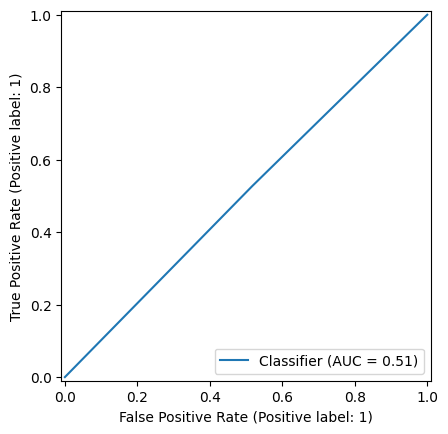

In [ ]:
# Evaluate Model Classification Performance in the Test Set with "Best" hyperparameter settings
# final model evaluation
finalModel = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=2025,
                          max_depth = 6, min_child_weight = 1, subsample = 0.5970606684977592, learning_rate = 0.05637364430976246, n_estimators = 691)

finalModel.fit(X, y) # fit to the training data
ypred = finalModel.predict(XTest) # predictions on the hold-out test data
RocCurveDisplay.from_predictions(yTest, ypred)


Confusion Matrix
[[41 44]
 [34 38]]


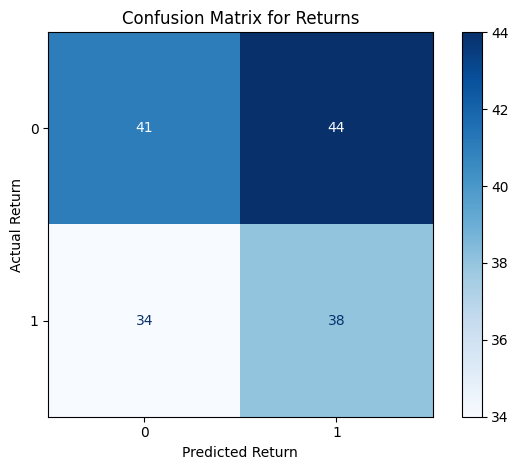

In [ ]:
print("Confusion Matrix")
print(confusion_matrix(yTest, ypred))
disp = ConfusionMatrixDisplay.from_predictions(yTest, ypred,
                              display_labels =["0","1"],
                                              cmap = plt.cm.Blues)
plt.title("Confusion Matrix for Returns")
plt.xlabel("Predicted Return")
plt.ylabel("Actual Return")
plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(yTest, ypred, labels = ["0","1"]))

              precision    recall  f1-score   support

           0       0.55      0.48      0.51        85
           1       0.46      0.53      0.49        72

   micro avg       0.50      0.50      0.50       157
   macro avg       0.51      0.51      0.50       157
weighted avg       0.51      0.50      0.50       157



In [ ]:
# Assess and print feature importances
model.fit(X, y)
print(model.feature_importances_)

[0.0485498  0.05014864 0.04153407 0.04655541 0.0437216  0.04683292
 0.04472881 0.04442059 0.04525414 0.04386874 0.04124043 0.04550721
 0.04161915 0.04029098 0.04140518 0.03696298 0.03331797 0.04327295
 0.03996009 0.0403973  0.03649111 0.03022377 0.03888723 0.03480893]


### Ranking Features by Importance
This completes the exploration of additional features being added to the mix. Now we identify which of those features are most important in classifying the next day's return direction (up or even/down).


In [ ]:
featureNames = wtiTrainETF.columns
print("Feature names correspond to Numpy array columns:",featureNames)

# Get feature importances
importances = np.round(model.feature_importances_, decimals = 3)

# Create Polars DataFrame
importanceDF = pl.DataFrame({"feature": featureNames, "importance": importances})

with pl.Config(
    tbl_rows = 60):
    print(importanceDF.sort("importance", descending=True))

Feature names correspond to Numpy array columns: ['CloseLag1', 'CloseLag2', 'CloseLag3', 'HMLLag1', 'HMLLag2', 'HMLLag3', 'OMCLag1', 'OMCLag2', 'OMCLag3', 'VolumeLag1', 'VolumeLag2', 'VolumeLag3', 'CloseEMA2', 'CloseEMA4', 'CloseEMA8', 'SPYUp', 'GLDUp', 'VGTUp', 'VBUp', 'IVEUp', 'XLIUp', 'XLUUp', 'SLVUp', 'USOUp']
shape: (24, 2)
┌────────────┬────────────┐
│ feature    ┆ importance │
│ ---        ┆ ---        │
│ str        ┆ f32        │
╞════════════╪════════════╡
│ CloseLag2  ┆ 0.05       │
│ CloseLag1  ┆ 0.049      │
│ HMLLag1    ┆ 0.047      │
│ HMLLag3    ┆ 0.047      │
│ VolumeLag3 ┆ 0.046      │
│ OMCLag1    ┆ 0.045      │
│ OMCLag3    ┆ 0.045      │
│ HMLLag2    ┆ 0.044      │
│ OMCLag2    ┆ 0.044      │
│ VolumeLag1 ┆ 0.044      │
│ VGTUp      ┆ 0.043      │
│ CloseLag3  ┆ 0.042      │
│ CloseEMA2  ┆ 0.042      │
│ VolumeLag2 ┆ 0.041      │
│ CloseEMA8  ┆ 0.041      │
│ CloseEMA4  ┆ 0.04       │
│ VBUp       ┆ 0.04       │
│ IVEUp      ┆ 0.04       │
│ SLVUp      ┆ 0.039     

### Repeat the Modeling Process
For subsequent model development, we can retain the top features and then run additional tests with new features using the procedure demonstrated in this analysis


## References

* [yfinance GitHub](https://github.com/ranaroussi/yfinance)
* [yfinance Documentation](https://ranaroussi.github.io/yfinance/)
* [Polars Online User Guide](https://docs.pola.rs/)
* [Build Polars Database](https://www.pyquantnews.com/free-python-resources/build-stock-database-locally-with-polars)
* [YouTube. Polars and Time Series: What It Can Do, and How to Overcome Any Limitation](https://www.youtube.com/watch?v=qz-zAHBz6Ks)
* [Awesome Quant: Python for Quantiative Finance](https://wilsonfreitas.github.io/awesome-quant/)
* [Cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html)
* [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)
* [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
* [Hyperparameter Tuning](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)
* [Metrics and Scoring](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)
* [Introduction to Boosted Trees](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
* [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/index.html)
* [XGBoost in Python documentation](https://xgboost-clone.readthedocs.io/en/latest/python/python_intro.html)
* [Auto-Sklearn for AutoML in an Scikit-Learn Environment](https://www.automl.org/automl-for-x/tabular-data/auto-sklearn/).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# list of the ETF tickers
etfs = ['spy', 'gld', 'ive', 'slv', 'uso', 'vb', 'vgt', 'xli', 'xlu']
etf_dfs = {}

# Loop through each ETF to reate the 'Up' feature
for etf in etfs:
    file_path = f"/content/{etf}_daily_data.csv"
    try:
        df = pl.read_csv(file_path, try_parse_dates=True)
        # Drop irrelevant columns
        df = df.drop(['Dividends', 'StockSplits'])
        # Create lagged closing price for previous day
        df = df.with_columns(pl.col('Close').shift(1).alias('CloseLag1'))
        # Create the 'Up' feature based on yesterday's price
        df = df.with_columns(
            (pl.col('Close').shift(-1) > pl.col('Close')).alias(f'{etf}Up').cast(pl.Int32)
        )
        etf_dfs[etf] = df
    except pl.ColumnNotFoundError as e:
        print(f"Column missing in {etf}: {e}. Skipping this ETF.")
    except Exception as e:
        print(f"Error processing {etf}: {e}. Skipping this ETF.")

if 'spy' in etf_dfs:
    print(etf_dfs['spy'].head())

shape: (5, 9)
┌─────────────┬───────────┬───────────┬───────────┬───┬──────────┬─────────────┬───────────┬───────┐
│ Date        ┆ Open      ┆ High      ┆ Low       ┆ … ┆ Volume   ┆ CapitalGain ┆ CloseLag1 ┆ spyUp │
│ ---         ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---      ┆ s           ┆ ---       ┆ ---   │
│ datetime[μs ┆ f64       ┆ f64       ┆ f64       ┆   ┆ i64      ┆ ---         ┆ f64       ┆ i32   │
│ , UTC]      ┆           ┆           ┆           ┆   ┆          ┆ f64         ┆           ┆       │
╞═════════════╪═══════════╪═══════════╪═══════════╪═══╪══════════╪═════════════╪═══════════╪═══════╡
│ 2000-01-03  ┆ 93.924388 ┆ 93.924388 ┆ 91.152589 ┆ … ┆ 8164300  ┆ 0.0         ┆ null      ┆ 0     │
│ 05:00:00    ┆           ┆           ┆           ┆   ┆          ┆             ┆           ┆       │
│ UTC         ┆           ┆           ┆           ┆   ┆          ┆             ┆           ┆       │
│ 2000-01-04  ┆ 90.934811 ┆ 91.271387 ┆ 88.46989  ┆ … ┆ 8089800  ┆ 0.0       

In [ ]:
#  read prepared wti
wti = pl.read_csv("/content/wti-with-computed-features.csv", try_parse_dates=True)

# merge WTI with each ETF df
for etf, df in etf_dfs.items():
    wti = wti.join(df.select(['Date', f'{etf}Up']), on='Date', how='left')

# drop NAs
wti = wti.drop_nulls()

# separate features and target
etf_features = [f'{etf}Up' for etf in etfs]
base_features = wti.columns[1:13]
X_columns = base_features + etf_features

X = wti.select(X_columns).to_numpy()
y = wti['Target'].to_numpy()
dates = wti['Date'].to_numpy()

In [ ]:
# TimeSeriesSplit with a gap to prevent look-ahead bias
tscv = TimeSeriesSplit(n_splits=5, gap=10)

# initialize CatBoost and XGBoost
models = {
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)
}

# Train and evaluate each model using cross-validation
for name, model in models.items():
    print(f"Training and evaluating {name}...")
    cv_results = cross_validate(model, X, y, cv=tscv, scoring=['accuracy', 'roc_auc'], return_train_score=False)
    print(f"{name} Cross-Validation Results:")
    print(f"  Accuracy: {cv_results['test_accuracy'].mean():.4f} +/- {cv_results['test_accuracy'].std():.4f}")
    print(f"  AUC: {cv_results['test_roc_auc'].mean():.4f} +/- {cv_results['test_roc_auc'].std():.4f}")

Training and evaluating CatBoost...
CatBoost Cross-Validation Results:
  Accuracy: 0.6494 +/- 0.0917
  AUC: 0.7146 +/- 0.1055
Training and evaluating XGBoost...
XGBoost Cross-Validation Results:
  Accuracy: 0.7046 +/- 0.0631
  AUC: 0.7749 +/- 0.0824


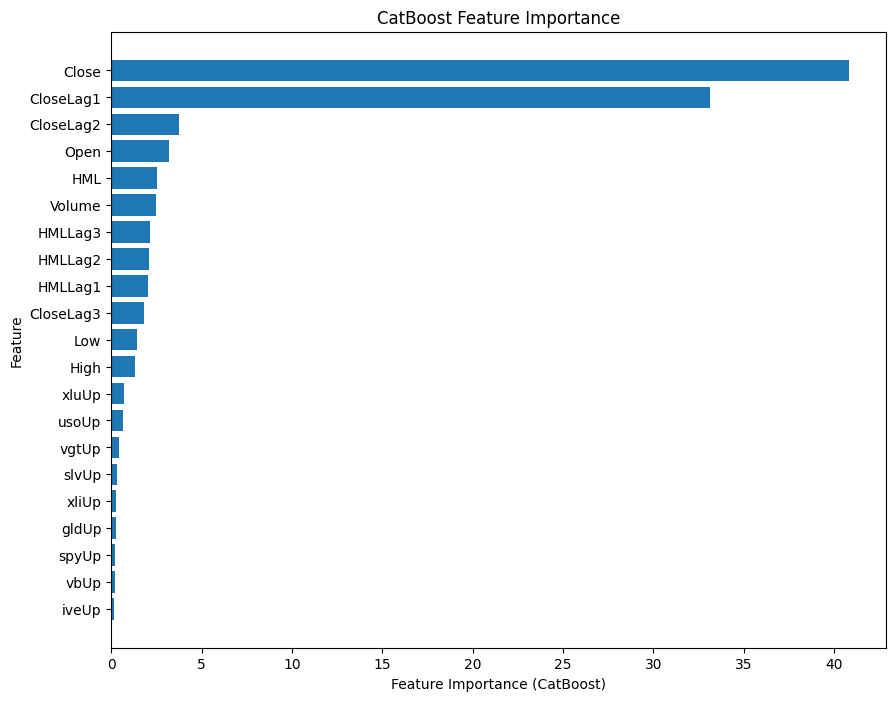

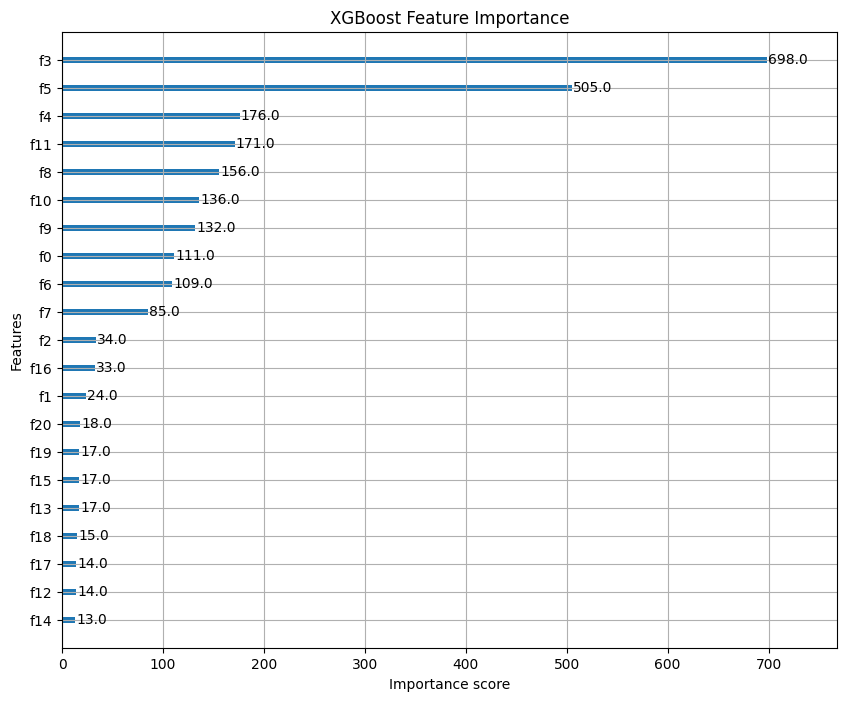

In [ ]:
# Re-fit CatBoost model on the full dataset to get feature importance
catboost_model = CatBoostClassifier(verbose=0, random_state=42)
catboost_model.fit(X, y)

# Get feature importance and feature names
feature_importance = catboost_model.get_feature_importance()
sorted_idx = np.argsort(feature_importance)
sorted_features = np.array(X_columns)[sorted_idx]

# Plot feature importance for CatBoost
plt.figure(figsize=(10, 8))
plt.barh(sorted_features, feature_importance[sorted_idx])
plt.xlabel("Feature Importance (CatBoost)")
plt.ylabel("Feature")
plt.title("CatBoost Feature Importance")
plt.show()

# Re-fit XGBoost model on the full dataset to get feature importance
xgboost_model = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)
xgboost_model.fit(X, y)

# Plot feature importance for XGBoost
plt.figure(figsize=(10, 8))
plot_importance(xgboost_model, ax=plt.gca())
plt.title("XGBoost Feature Importance")
plt.show()

apply momentum signal and EMA

Beginning Backtests...

Aggressive Strategy Results
Final Capital: $44265.67

Moderate Strategy Results
Final Capital: $45881.17

Conservative Strategy Results
Final Capital: $43900.19


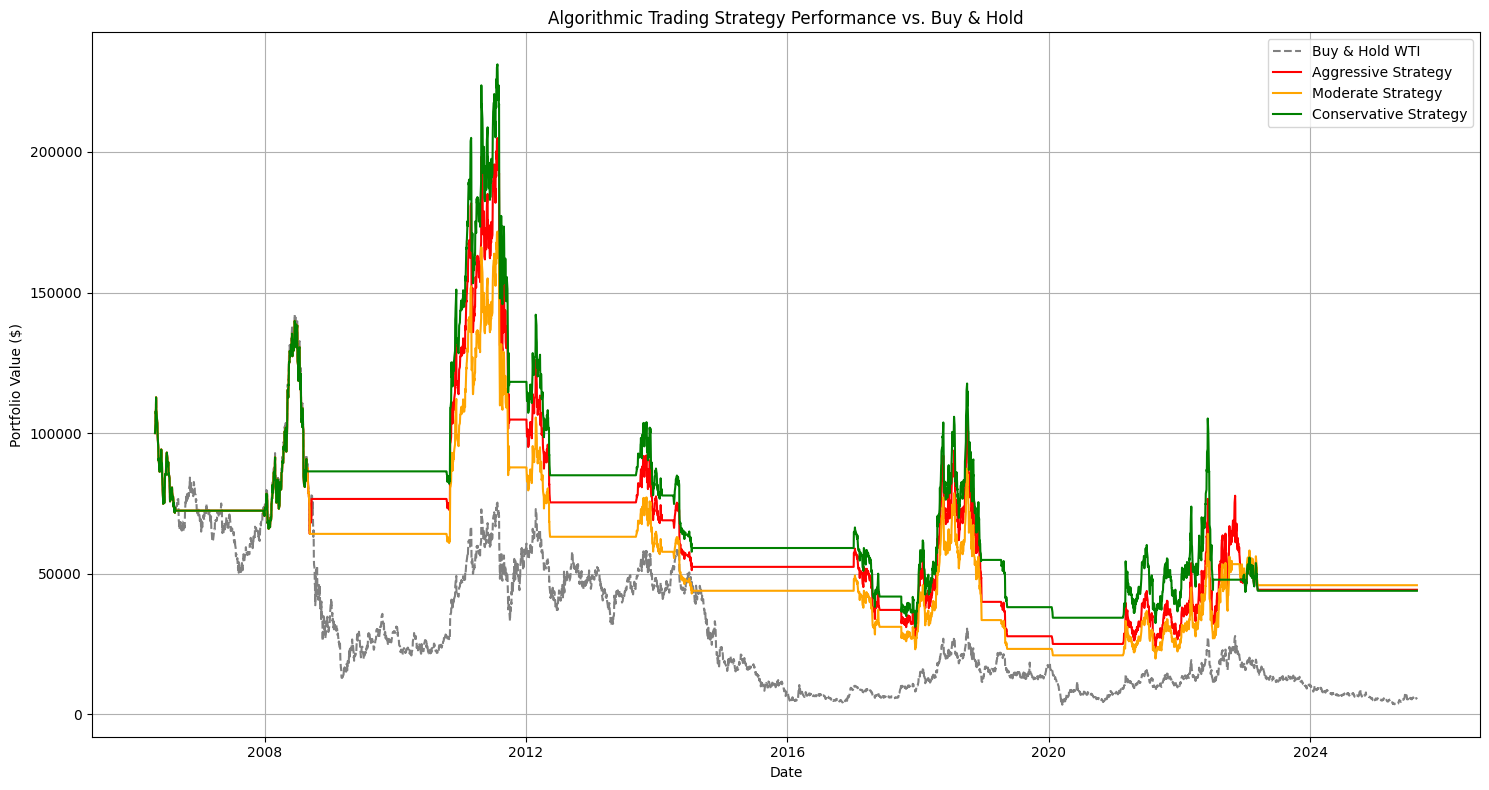

In [61]:
import polars as pl
import matplotlib.pyplot as plt

def compute_ema(df: pl.DataFrame, column: str, window: int) -> pl.Series:
    """
    Computes the EMA for a given column.
    """
    return df.get_column(column).ewm_mean(com=window)

def create_momentum_signal(df: pl.DataFrame, col_40: str, col_80: str) -> pl.Series:
    """
    Creates a binary momentum signal: 1 if 40-day EMA > 80-day EMA, 0 otherwise.
    """
    return (df[col_40] > df[col_80]).cast(pl.Int32)

def backtest_strategy(data: pl.DataFrame, signal_columns: list, initial_capital: float = 100000.0, risk_level: str = 'aggressive') -> pl.DataFrame:
    """
    Performs a backtest of a multi-level momentum trading strategy based on risk tolerance.

    Args:
        data (pl.DataFrame): The DataFrame with all price and signal data.
        signal_columns (list): A list of columns to use as signals for the strategy.
        initial_capital (float): The starting capital for the simulation.
        risk_level (str): 'aggressive', 'moderate', or 'conservative'.

    Returns:
        pl.DataFrame: A DataFrame with the daily portfolio value.
    """
    cash = initial_capital
    position = 0
    portfolio_history = []

    # Aggressive: Buy if WTI signal is 1
    # Moderate: Buy if WTI signal is 1 AND at least 2 ETF signals are 1
    # Conservative: Buy if WTI signal is 1 AND at least 3 ETF signals are 1

    for i in range(len(data)):
        current_date = data['Date'][i]
        current_price = data['Close'][i]

        # Determine the number of active buy signals for the current day
        active_signals = sum([data[col][i] for col in signal_columns])
        wti_signal = data[signal_columns[0]][i]

        # Check buy condition based on risk level
        buy_condition = False
        if risk_level == 'aggressive' and wti_signal == 1:
            buy_condition = True
        elif risk_level == 'moderate' and wti_signal == 1 and active_signals >= 3:
            buy_condition = True
        elif risk_level == 'conservative' and wti_signal == 1 and active_signals >= 4:
            buy_condition = True

        # Check sell condition
        sell_condition = not buy_condition and position > 0

        # Trading logic
        if buy_condition and position == 0:
            if cash > 0:
                shares_to_buy = int(cash / current_price)
                if shares_to_buy > 0:
                    cash -= shares_to_buy * current_price
                    position += shares_to_buy
        elif sell_condition:
            cash += position * current_price
            position = 0

        # Record portfolio value at the end of the day
        current_value = cash + (position * current_price)
        portfolio_history.append({'date': current_date, 'value': current_value})

    return pl.DataFrame(portfolio_history)

# rUN
if __name__ == "__main__":

    # Load WTI data and create the new EMA features
    wti_df = pl.read_csv("/content/wti-with-computed-features.csv", try_parse_dates=True)
    wti_df = wti_df.sort("Date")

    etfs = ['spy', 'gld', 'ive', 'slv', 'uso', 'vb', 'vgt', 'xli', 'xlu']

    # Compute 40-day and 80-day EMAs for WTI
    wti_df = wti_df.with_columns(
        compute_ema(wti_df, 'Close', 40).alias('40d_ema'),
        compute_ema(wti_df, 'Close', 80).alias('80d_ema')
    )
    # Create WTI momentum signal
    wti_df = wti_df.with_columns(
        create_momentum_signal(wti_df, '40d_ema', '80d_ema').alias('WTI_signal')
    )

    # Load ETF data, create momentum signals, and merge
    main_df = wti_df
    signal_columns = ['WTI_signal']

    for ticker in etfs:
        try:
            etf_df = pl.read_csv(f"/content/{ticker}_daily_data.csv", try_parse_dates=True)
            etf_df = etf_df.sort("Date")
            etf_df = etf_df.with_columns(
                compute_ema(etf_df, 'Close', 40).alias(f'{ticker}_40d_ema'),
                compute_ema(etf_df, 'Close', 80).alias(f'{ticker}_80d_ema')
            )
            etf_df = etf_df.with_columns(
                create_momentum_signal(etf_df, f'{ticker}_40d_ema', f'{ticker}_80d_ema').alias(f'{ticker}_signal')
            )
            main_df = main_df.join(etf_df.select(['Date', f'{ticker}_signal']), on='Date', how='left')
            signal_columns.append(f'{ticker}_signal')

        except Exception as e:
            print(f"Could not process {ticker}: {e}")
            continue

    # Drop NAs
    main_df = main_df.drop_nulls()

    # Perform backtests for different risk levels
    print("Beginning Backtests...")

    # Aggressive Strategy
    portfolio_aggressive = backtest_strategy(main_df, signal_columns, risk_level='aggressive')
    final_capital_aggressive = portfolio_aggressive.get_column('value')[-1]
    print("\nAggressive Strategy Results")
    print(f"Final Capital: ${final_capital_aggressive:.2f}")

    # Moderate Strategy
    portfolio_moderate = backtest_strategy(main_df, signal_columns, risk_level='moderate')
    final_capital_moderate = portfolio_moderate.get_column('value')[-1]
    print("\nModerate Strategy Results")
    print(f"Final Capital: ${final_capital_moderate:.2f}")

    # Conservative Strategy
    portfolio_conservative = backtest_strategy(main_df, signal_columns, risk_level='conservative')
    final_capital_conservative = portfolio_conservative.get_column('value')[-1]
    print("\nConservative Strategy Results")
    print(f"Final Capital: ${final_capital_conservative:.2f}")

    # Plot the results
    fig, ax = plt.subplots(figsize=(15, 8))

    # Calculate and plot Buy & Hold performance
    initial_capital = 100000.0
    buy_and_hold_values = (main_df['Close'] / main_df['Close'][0]) * initial_capital
    ax.plot(main_df['Date'], buy_and_hold_values, label='Buy & Hold WTI', color='gray', linestyle='--')

    ax.plot(portfolio_aggressive.get_column('date'), portfolio_aggressive.get_column('value'), label='Aggressive Strategy', color='red')
    ax.plot(portfolio_moderate.get_column('date'), portfolio_moderate.get_column('value'), label='Moderate Strategy', color='orange')
    ax.plot(portfolio_conservative.get_column('date'), portfolio_conservative.get_column('value'), label='Conservative Strategy', color='green')

    ax.set_title('Algorithmic Trading Strategy Performance vs. Buy & Hold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value ($)')
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()


WTI Momentum Strategy Backtest Results:
shape: (24, 5)
┌─────────────────────────┬──────┬────────┬────────┬─────────────┐
│ date                    ┆ type ┆ shares ┆ price  ┆ total_value │
│ ---                     ┆ ---  ┆ ---    ┆ ---    ┆ ---         │
│ datetime[μs, UTC]       ┆ str  ┆ i64    ┆ f64    ┆ f64         │
╞═════════════════════════╪══════╪════════╪════════╪═════════════╡
│ 2005-02-10 05:00:00 UTC ┆ BUY  ┆ 7282   ┆ 13.732 ┆ 99996.424   │
│ 2006-08-21 04:00:00 UTC ┆ SELL ┆ 7282   ┆ 22.487 ┆ 163750.334  │
│ 2007-12-26 05:00:00 UTC ┆ BUY  ┆ 7164   ┆ 22.857 ┆ 163747.548  │
│ 2008-09-19 04:00:00 UTC ┆ SELL ┆ 7164   ┆ 24.175 ┆ 173189.7    │
│ 2010-10-13 04:00:00 UTC ┆ BUY  ┆ 19827  ┆ 8.735  ┆ 173188.845  │
│ …                       ┆ …    ┆ …      ┆ …      ┆ …           │
│ 2019-05-13 04:00:00 UTC ┆ SELL ┆ 13534  ┆ 4.632  ┆ 62689.488   │
│ 2020-01-17 05:00:00 UTC ┆ BUY  ┆ 12619  ┆ 4.968  ┆ 62691.192   │
│ 2020-01-23 05:00:00 UTC ┆ SELL ┆ 12619  ┆ 4.478  ┆ 56507.882   │
│ 2021-

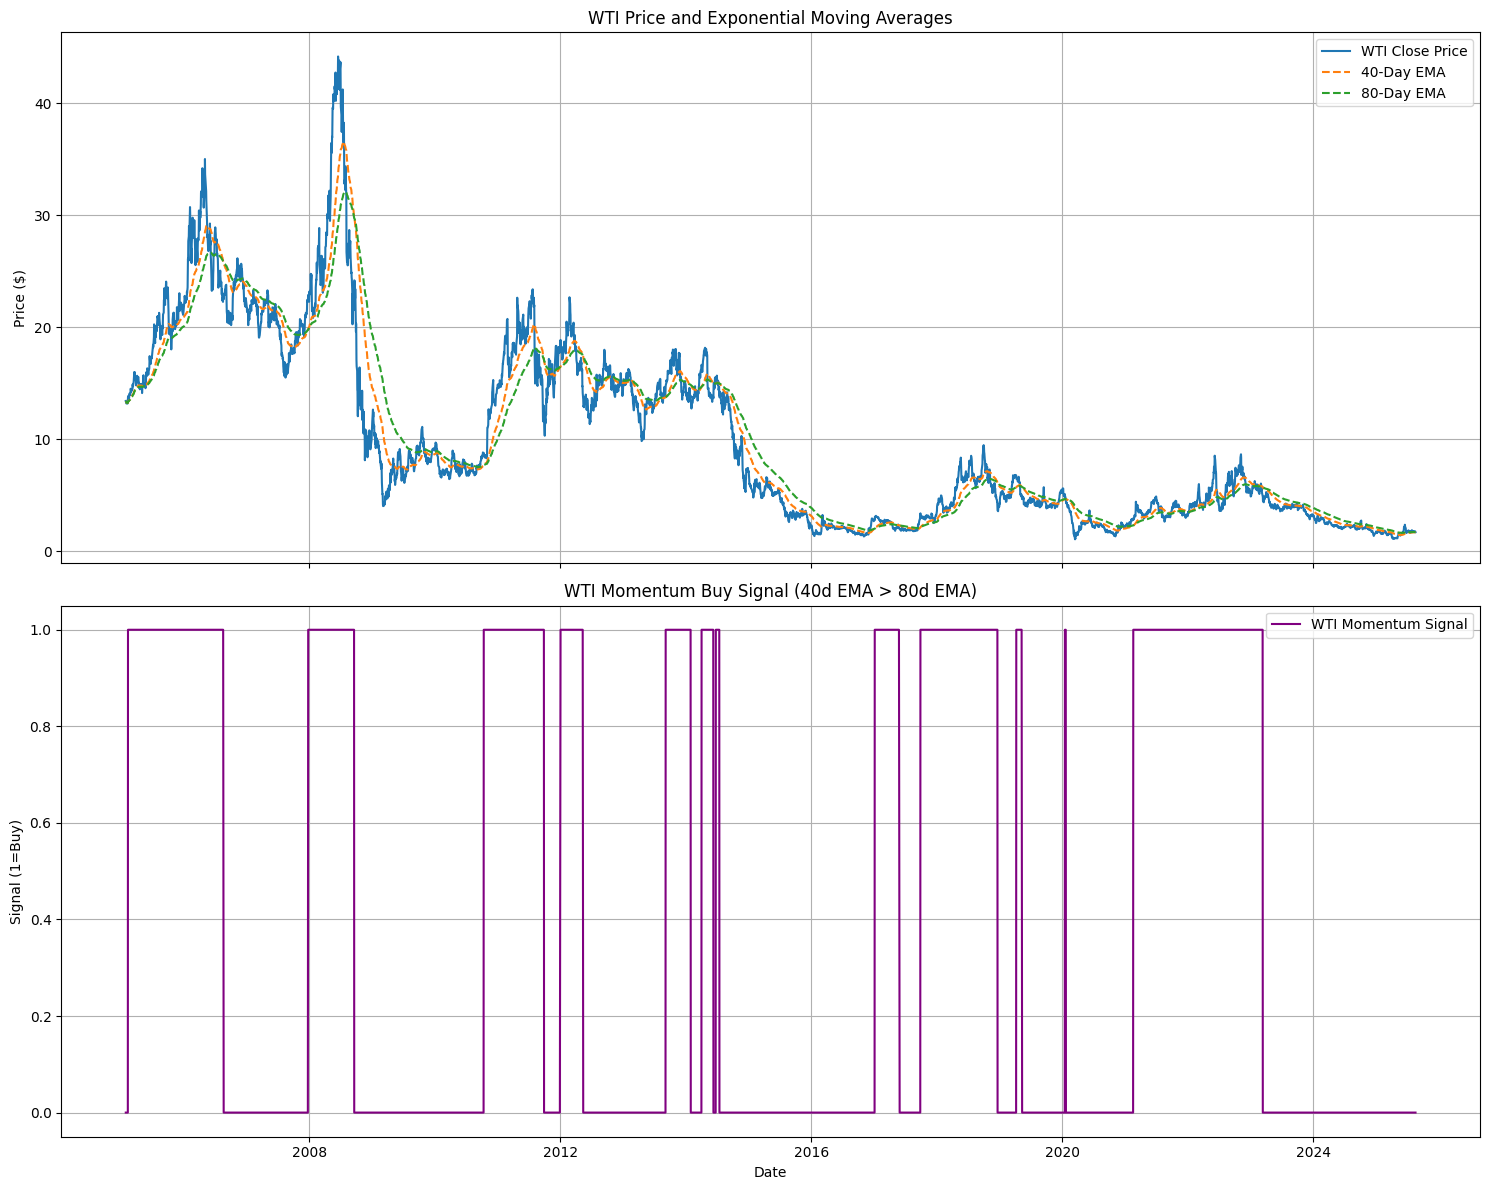

In [62]:
import polars as pl
import matplotlib.pyplot as plt

def compute_ema(df: pl.DataFrame, column: str, window: int) -> pl.Series:
    """
    Computes the Exponential Moving Average (EMA) for a given column.
    """
    return df.get_column(column).ewm_mean(com=window)

def create_momentum_signal(df: pl.DataFrame, col_40: str, col_80: str) -> pl.Series:
    """
    Creates a binary momentum signal: 1 if 40-day EMA > 80-day EMA, 0 otherwise.
    """
    return (df[col_40] > df[col_80]).cast(pl.Int32)

def backtest_strategy(data: pl.DataFrame, signal_column: str, initial_capital: float = 100000.0) -> tuple:
    """
    Performs a simple backtest of the momentum trading strategy.
    """
    cash = initial_capital
    position = 0
    trade_log = []

    # Iterate through the data day by day
    for i in range(1, len(data)):
        current_date = data['Date'][i]
        current_price = data['Close'][i]
        previous_signal = data[signal_column][i - 1]
        current_signal = data[signal_column][i]

        # Buy signal: previous signal was 0, current is 1, and no current position
        if previous_signal == 0 and current_signal == 1 and position == 0:
            if cash > 0:
                shares_to_buy = int(cash / current_price)
                if shares_to_buy > 0:
                    cost = shares_to_buy * current_price
                    cash -= cost
                    position += shares_to_buy
                    trade_log.append({
                        'date': current_date,
                        'type': 'BUY',
                        'shares': shares_to_buy,
                        'price': current_price,
                        'total_value': cost
                    })

        # Sell signal: previous signal was 1, current is 0, and there is a position
        elif previous_signal == 1 and current_signal == 0 and position > 0:
            revenue = position * current_price
            cash += revenue
            trade_log.append({
                'date': current_date,
                'type': 'SELL',
                'shares': position,
                'price': current_price,
                'total_value': revenue
            })
            position = 0

    # Close any open position at the end of the simulation
    if position > 0:
        final_value = position * data['Close'][len(data) - 1]
        cash += final_value
        trade_log.append({
            'date': data['Date'][len(data) - 1],
            'type': 'FINAL SELL',
            'shares': position,
            'price': data['Close'][len(data) - 1],
            'total_value': final_value
        })

    final_capital = cash + (position * data['Close'][len(data) - 1])
    trade_df = pl.DataFrame(trade_log)

    return trade_df, final_capital

# Run
if __name__ == "__main__":

    # Load WTI data and create the new EMA features
    wti_df = pl.read_csv("/content/wti-with-computed-features.csv", try_parse_dates=True)
    wti_df = wti_df.sort("Date")

    # Compute 40-day and 80-day EMAs for WTI
    wti_df = wti_df.with_columns(
        compute_ema(wti_df, 'Close', 40).alias('40d_ema'),
        compute_ema(wti_df, 'Close', 80).alias('80d_ema')
    )

    # Create the WTI momentum signal
    wti_df = wti_df.with_columns(
        create_momentum_signal(wti_df, '40d_ema', '80d_ema').alias('WTIMomentumSignal')
    )

    # Perform a backtest on the WTI momentum strategy
    trade_log, final_capital = backtest_strategy(wti_df.drop_nulls(), 'WTIMomentumSignal')

    print("WTI Momentum Strategy Backtest Results:")
    print(trade_log)
    print(f"\nInitial Capital: $100,000.00")
    print(f"Final Capital: ${final_capital:.2f}")

    # Plot results
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

    # Plot the WTI closing price and EMAs
    ax1.plot(wti_df['Date'], wti_df['Close'], label='WTI Close Price')
    ax1.plot(wti_df['Date'], wti_df['40d_ema'], label='40-Day EMA', linestyle='--')
    ax1.plot(wti_df['Date'], wti_df['80d_ema'], label='80-Day EMA', linestyle='--')
    ax1.set_title('WTI Price and Exponential Moving Averages')
    ax1.set_ylabel('Price ($)')
    ax1.grid(True)
    ax1.legend()

    # Plot the momentum signal
    ax2.plot(wti_df['Date'], wti_df['WTIMomentumSignal'], label='WTI Momentum Signal', color='purple')
    ax2.set_title('WTI Momentum Buy Signal (40d EMA > 80d EMA)')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Signal (1=Buy)')
    ax2.grid(True)
    ax2.legend()
    plt.tight_layout()
    plt.show()
